In [ ]:
# default_exp core

# module name here

> API details.

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#export
from fastcore.all import *
from fastai.data.all import *
from fastai.vision.core import *
from fastai.vision.data import *
from fastai.basics import *
from fastai.vision.gan import *
from fastai.vision.models.all import *
from fastai.vision.augment import *

## Explode Functions

These are function that are useful for debugging.

In [ ]:
#export
def explode_types(o):
    '''Like fastcore explode_types, but only shows __name__ of type.'''
    if not is_listy(o): return type(o).__name__
    return {type(o).__name__: [explode_types(o_) for o_ in o]}

In [ ]:
#export
def explode_lens(o):
    if is_listy(o):
        if all(is_listy(o_) for o_ in o):
            return [explode_lens(o_) for o_ in o]
        else: return len(o)

In [ ]:
test_eq(explode_lens([[1,4], [[5,6,7], [1]]]), [2, [3, 1]])

In [ ]:
#export
def explode_shapes(o):
    if not is_listy(o): return tuple(bind(getattr, arg0, 'shape')(o))
    return [explode_shapes(o_) for o_ in o]

In [ ]:
test_eq(explode_shapes([tensor([1,4]), [tensor([[4,5],[7,8]]), tensor([6])]]), [(2,), [(2,2), (1,)]])

In [ ]:
#export
def explode_ranges(o):
    if not is_listy(o): return (float(o.min()), float(o.max()))
    return [explode_ranges(o_) for o_ in o]

In [ ]:
explode_ranges([tensor([1,4]), [tensor([[4,5],[7,8]]), tensor([6])]])

[(1.0, 4.0), [(4.0, 8.0), (6.0, 6.0)]]

## N Images Classes

These are classes to handle many images to many images generation

In [ ]:
#export 
class ImageNTuple(fastuple):
    @classmethod
    def create(cls, fns): return cls(tuple(PILImage.create(f) for f in fns))
    
    def show(self, ctx=None, **kwargs): 
        all_tensors = all([isinstance(t, Tensor) for t in self])
        same_shape = all([self[0].shape==t.shape for t in self[1:]])
        if not all_tensors or not same_shape: return ctx
        line = self[0].new_zeros(self[0].shape[0], self[0].shape[1], 10)
        imgs = sum(L(zip(self, [line]*len(self))).map(list),[])
        return show_image(torch.cat(imgs, dim=2), ctx=ctx, **kwargs)
    
    def requires_grad_(self, value):
        for item in self: item.requires_grad_(value)
        return self

In [ ]:
path = untar_data(URLs.PETS)
files = get_image_files(path/"images")

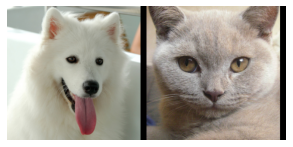

In [ ]:
imt2 = ImageNTuple.create((files[0], files[1]))
imt2 = Resize(224)(imt2)
imt2 = ToTensor()(imt2)
imt2.show();

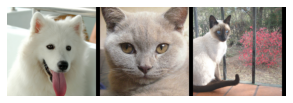

In [ ]:
imt3 = ImageNTuple.create((files[0], files[1], files[2]))
imt3 = Resize(224)(imt3)
imt3 = ToTensor()(imt3)
imt3.show();

In [ ]:
test_eq(len(imt2), 2)
test_eq(len(imt3), 3)

In [ ]:
# export
def ImageTupleBlock(): 
    '''Like fastai tutoria siemese transform, but uses ImageNTuple.'''
    return TransformBlock(type_tfms=ImageNTuple.create, batch_tfms=[IntToFloatTensor])

In [ ]:
#export
class ConditionalGenerator(nn.Module):
    '''Wraper around a GAN generator that returns the generated image and the input.'''
    def __init__(self, gen_base, *args, **kwargs):
        super().__init__()
        self.gen = DynamicUnet(gen_base, *args, **kwargs)
    def forward(self, x):
        if is_listy(x):
            input = torch.cat(x, axis=1)
        else:
            input = x
        return ImageNTuple(x, TensorImage(self.gen(input)))

Test that the ConditionalGenerator can generate images from one image

In [ ]:
gen_base = gan_critic(n_channels=3, nf=64)
gen_base = nn.Sequential(*list(gen_base.children())[:-2])
gen = ConditionalGenerator(gen_base,3, (256, 256), 
                           norm_type=NormType.Spectral, 
                           y_range=(-1,1),
                           act_cls=partial(nn.LeakyReLU, negative_slope=0.2, inplace=True)
                           )

In [ ]:
out = gen(torch.rand(1, 3, 256, 256))

In [ ]:
test_eq(explode_shapes(out), [(1, 3, 256, 256), (1, 3, 256, 256)])

In [ ]:
test_eq(type(out), ImageNTuple)

Test that the ConditionalGenerator can generate an image from two images

In [ ]:
gen_base = gan_critic(n_channels=6, nf=64)
gen_base = nn.Sequential(*list(gen_base.children())[:-2])
gen = ConditionalGenerator(gen_base,3, (224, 224), 
                           norm_type=NormType.Spectral, 
                           y_range=(-1,1),
                           act_cls=partial(nn.LeakyReLU, negative_slope=0.2, inplace=True)
                           )

In [ ]:
dl = DataLoader(dataset=([imt2]), bs=1, after_item=IntToFloatTensor())
b = first(dl)
out = gen(b)

In [ ]:
test_eq(type(out), ImageNTuple)
test_eq(len(out), 3)

In [ ]:
#export
class SiameseCritic(Module):
    def __init__(self, *args, **kwargs): self.critic = gan_critic(*args, **kwargs)
    def forward(self, x): return self.critic(torch.cat(x, dim=1))

In [ ]:
scritic = SiameseCritic(n_channels=6, nf=64)

## GAN Metrics

These are Metrics that work with GANLearner

In [ ]:
#export
class GenMetric(AvgMetric):
    def accumulate(self, learn):
        if learn.model.gen_mode:
            super().accumulate(learn)

In [ ]:
#export
class CriticMetric(AvgMetric):
    def accumulate(self, learn):
        if not learn.model.gen_mode:
            super().accumulate(learn)

In [ ]:
#export
def l1(output, target): return nn.L1Loss()(output[-1], target[-1])
l1 = GenMetric(l1)

## Show Results for TupleNImage

In [ ]:
#export
@typedispatch
def show_results(x:TensorImage, y:ImageNTuple, samples, outs, ctxs=None, max_n=6, nrows=None, ncols=2, figsize=None, **kwargs):
    max_n = min(x.shape[0], max_n)
    if max_n<ncols: ncols = max_n
    if figsize is None: figsize = (ncols*6, max_n//ncols * 3)
    if ctxs is None: ctxs = get_grid(min(x[0].shape[0], max_n), nrows=None, ncols=ncols, figsize=figsize)
    for i,ctx in enumerate(ctxs): 
        title = 'Input-Real-Fake'
        ImageNTuple(x[i], y[1][i], outs[i][0][1]).show(ctx=ctx, title=title)

## Tuple in Ys Learner Fix

Learner.show_results and Learner.predict thowgh an error if the ys are tuples. Let's fix that

In [ ]:
#export
@patch
def show_results(self:GANLearner, ds_idx=1, dl=None, max_n=9, shuffle=True, **kwargs):
    if dl is None: dl = self.dls[ds_idx].new(shuffle=shuffle)
    b = dl.one_batch()
    _,_,preds = self.get_preds(dl=[b], with_decoded=True)
    preds = (preds,)
    self.dls.show_results(b, preds, max_n=max_n, **kwargs)

In [ ]:
#exort
@patch
def predict(self:Learner, item, rm_type_tfms=None, with_input=False):
    dl = self.dls.test_dl([item], rm_type_tfms=rm_type_tfms, num_workers=0)
    inp,preds,_,dec_preds = self.get_preds(dl=dl, with_input=True, with_decoded=True)
    i = getattr(self.dls, 'n_inp', -1)
    inp = (inp,) if i==1 else tuplify(inp)
    n_out = len(self.dls.tls) - i
    dec_preds = (dec_preds,) if n_out==1 else tuplify(dec_preds)
    dec = self.dls.decode_batch(inp + dec_preds)[0]
    dec_inp,dec_targ = map(detuplify, [dec[:i],dec[i:]])
    res = dec_targ,dec_preds[0],preds[0]
    if with_input: res = (dec_inp,) + res
    return res

In [ ]:
from nbdev.export import *
notebook2script()

Converted 00_core.ipynb.
Converted index.ipynb.
